In [1]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source
import itertools

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from toolbox.tools import plot_classification_error, k_fold, plot_tree_graph
from toolbox.plot_results import plot_tree_graph, plot_confusion_matrix, plot_roc_curve
from toolbox.gradient_search import grid_search_classifier

In [3]:
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

In [4]:
# Load data
y = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
X_train = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
X_test = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')

In [5]:
# Clean all the data
# Drop the call collumns from both data sets
call_cols_train = [col for col in X_train.columns if 'call' in col]
X_train = X_train.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in X_test.columns if 'call' in col]
X_test = X_test.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
X_train = X_train.T
X_test = X_test.T

# now clean the patient_data
y = y.replace({'ALL': 0, 'AML': 1})
y_train = y[y.index <= 38]
y_test = y[y.index > 38]

# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']

In [6]:
# Sort the indices in the data sets
X_train.index = pd.to_numeric(X_train.index) 
X_test.index = pd.to_numeric(X_test.index) 
X_train.sort_index(inplace=True) 
X_test.sort_index(inplace=True)

# Reset the indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

X_train = X_train.replace(np.inf, np.nan)
X_train = X_train.fillna(value = X_train.values.mean())

X_test = X_test.replace(np.inf, np.nan)
X_test = X_test.fillna(value = X_train.values.mean())

#
y = y.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Merge X data sets
X_complete = X_train.append(X_test)
X_complete= X_complete.reset_index(drop=True)
X_complete

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12


In [7]:
# PCA
pca = PCA()
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)
pca_complete = np.append(pca_train, pca_test, 0)

# Stack explained variance
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100

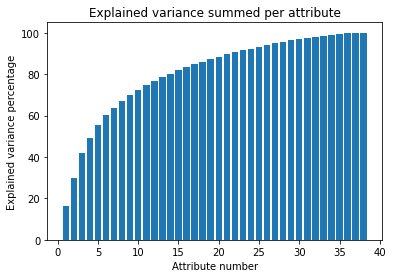

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 21 attributes that together explain 90% of the variance.


In [8]:
# Plot explained variance PCA
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i <= 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [9]:
#Crop pca_data for the useful number of attributes
pca_data = np.delete(pca_complete, slice(no_attributes, len(pca_complete)) , 1)

#Split data back to original train and test split
X_train_pca = pca_complete[:38]
X_test_pca = pca_complete[38:]
y = y.ravel()

# Decision tree

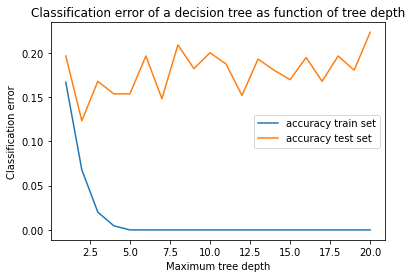

In [10]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'tree')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

In [11]:
parameters_tree = {
    'max_depth' : [2, 4, 6, 'None'],
    'min_samples_leaf' : [2, 4, 6],
    'criterion' : ['gini', 'entropy'],
    'random_state' : ['None', 10, 42]
}

predictions_tree, dtc = grid_search_classifier('tree', parameters_tree, X_train_pca, X_test_pca, y_train, y_test)

The best parameters for this model are: 
DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=4,
                       random_state=10)
This gives an accuracy of 0.7941176470588235 and an error of 0.20588235294117652


,param_criterion,param_max_depth,param_min_samples_leaf,param_random_state,mean_train_score,std_train_score
0,gini,2,2,None,NaN,NaN
1,gini,2,2,10,0.953277,0.014148
2,gini,2,2,42,0.953277,0.014148
3,gini,2,4,None,NaN,NaN
4,gini,2,4,10,0.935630,0.017771
5,gini,2,4,42,0.935630,0.017771
6,gini,2,6,None,NaN,NaN
7,gini,2,6,10,0.894790,0.013914
8,gini,2,6,42,0.894790,0.013914
9,gini,4,2,None,NaN,NaN


In [12]:
#predictions_tree, dtc = grid_search_classifier('tree', parameters_tree, X_train, X_test, y_train, y_test)

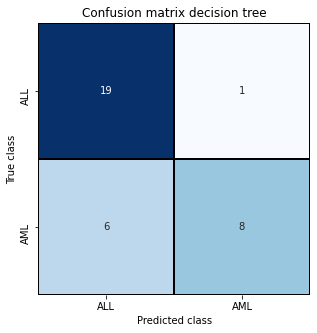

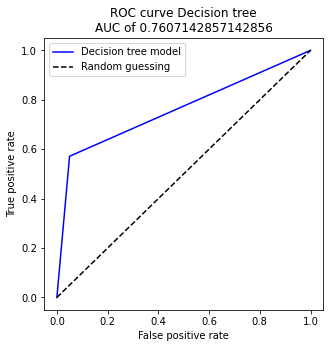

In [13]:
# Function for plotting the confusion matrices
conf_matrix_tree = metrics.confusion_matrix(y_test, predictions_tree)
plot_confusion_matrix(conf_matrix_tree, patient_labels, 'Confusion matrix decision tree')

plot_roc_curve(y_test, predictions_tree, 'Decision tree')

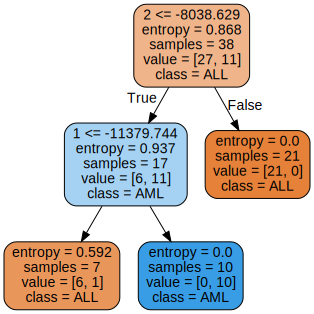

In [14]:
graph = plot_tree_graph(dtc, 1, no_attributes)
graph

# Random forest

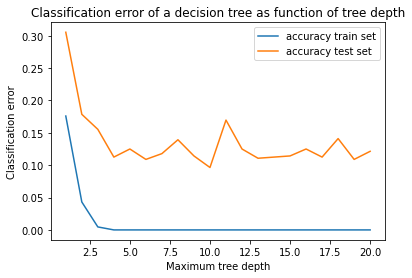

In [15]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'rf')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

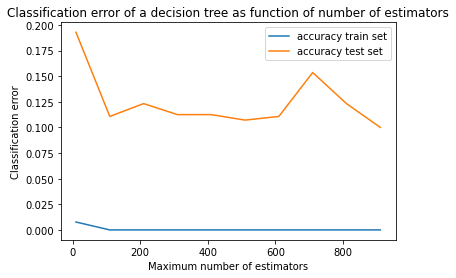

In [16]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 10, 1001, 100, 'rf_estimators')
plot_classification_error(10, 1001, 100, accuracy_mean_train_tree, accuracy_mean_test_tree, 'number of estimators')

In [17]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth = 4)
rf = rf.fit(X_train_pca, y_train)
accuracy = metrics.accuracy_score(y_test, rf.predict(X_test_pca))
print("The Random forest has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

<ipython-input-17-080ab08ecb57>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train_pca, y_train)


The Random forest has an accuracy of 0.7352941176470589 and an error rate of 0.2647058823529411.


In [18]:
parameters_rf = {
    'max_depth' : [2, 4, 6, 'None'],
    'n_estimators' : [250, 300, 350, 400],
    'min_samples_leaf' : [2, 4, 6],
    'criterion' : ['gini', 'entropy'],
    'random_state' : ['None', 10, 42]
}
predictions_rf, rf = grid_search_classifier('rf', parameters_rf, X_train_pca, X_test_pca, y_train, y_test)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Programmes\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-31db15699595>", line 8, in <module>
    predictions_rf, rf = grid_search_classifier('rf', parameters_rf, X_train_pca, X_test_pca, y_train, y_test)
  File "C:\Users\nhelm\Documents\Universiteit\Year 3\Data mining\Datamining\project\toolbox\gradient_search.py", line 20, in grid_search_classifier
    clf.fit(x_train, y_train)
  File "D:\Programmes\Anaconda\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "D:\Programmes\Anaconda\lib\site-packages\sklearn\model_selection\_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "D:\Programmes\Anaconda\lib\site-packages\sklearn\model_selection\_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "D:\Program

TypeError: object of type 'NoneType' has no len()

In [ ]:
#predictions_rf, rf = grid_search_classifier('rf', parameters_rf, X_train, X_test, y_train, y_test)

In [ ]:
conf_matrix_rf = metrics.confusion_matrix(y_test, predictions_rf)
plot_confusion_matrix(conf_matrix_rf, patient_labels, 'Confusion matrix random forest')

plot_roc_curve(y_test, predictions_rf, 'Random forest')

In [ ]:
estimator = rf.estimators_[100]
graph_rf = plot_tree_graph(estimator, 1, no_attributes)
graph_rf

# Gradient boosting tree

In [ ]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'rf')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

In [ ]:
accuracy_mean_train_tree, accuracy_mean_test_tree =  k_fold(pca_data, y, 10, 10, 101, 10, 'rf_estimators')
plot_classification_error(10, 101, 10, accuracy_mean_train_tree, accuracy_mean_test_tree, 'number of estimators')

In [20]:
xb = xgb.XGBClassifier(n_estimators = 50, max_depth = 5, eval_metric='error', use_label_encoder=False)
xb = xb.fit(X_train_pca, y_train)

accuracy = metrics.accuracy_score(y_test, xb.predict(X_test_pca))
print("The XGBoost has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

parameters_xgb = {
    'max_depth' : [2, 4, 6, 'None'],
    'n_estimators' : [450, 500],
    'random_state' : ['None', 10, 42],
    'eval_metric': ['rmse','mape', 'auc', 'error'],
    'use_label_encoder' : ['False']
}

predictions_xgb, xb = grid_search_classifier('xgb', parameters_xgb, X_train_pca, X_test_pca, y_train, y_test)

The XGBoost has an accuracy of 0.7941176470588235 and an error rate of 0.20588235294117652.
The best parameters for this model are: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=450, n_jobs=8,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder='False', validate_parameters=1, verbosity=None)
This gives an accuracy of 0.7941176470588235 and an error of 0.20588235294117652


D:\Programmes\Anaconda\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,param_eval_metric,param_n_estimators,param_max_depth,param_random_state,mean_train_score,std_train_score
0,rmse,450,2,None,NaN,NaN
1,rmse,450,2,10,1.0,0.0
2,rmse,450,2,42,1.0,0.0
3,rmse,500,2,None,NaN,NaN
4,rmse,500,2,10,1.0,0.0
5,rmse,500,2,42,1.0,0.0
6,rmse,450,4,None,NaN,NaN
7,rmse,450,4,10,1.0,0.0
8,rmse,450,4,42,1.0,0.0
9,rmse,500,4,None,NaN,NaN


In [ ]:
#predictions_xgb, xb = grid_search_classifier('xgb', parameters_xgb, X_train, X_test, y_train, y_test)

In [ ]:
conf_matrix_xb = metrics.confusion_matrix(y_test, predictions_xgb)
plot_confusion_matrix(conf_matrix_xb, patient_labels, 'Confusion matrix gradient boost')

plot_roc_curve(y_test, predictions_xgb, 'Gradient boost')

In [ ]:
cd = {'shape': 'box',
 'style': 'filled,rounded',
 'fillcolor': '#78bceb'}

lf = {'shape': 'box',
 'style': 'filled, rounded',
 'fillcolor': '#e48038'}

xgb.to_graphviz(xb,condition_node_params = cd, leaf_node_params = lf, num_trees=2, feature_names= "test")